# Exercise Sheet 02

- Johannes Sindlinger
- Daniel Knorr
- Marvin Hanf


# Datenanalyse von MakeMoon Dataset

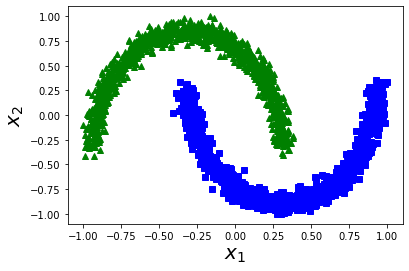

In [1]:
from sklearn.datasets import make_moons
 
# X are the generated instances, an array of shape (2000,2).
# y are the labels of X, with values of either 0 or 1.
X, y = make_moons(n_samples=2000, noise=0.05)


from matplotlib import pyplot as plt

# When the label y is 0, the class is represented with a blue square.
# When the label y is 1, the class is represented with a green triangle.

# X contains two features, x1 and x2
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20)
# ------------------------------

# standardize features to be in [-1, 1]
offset  = X.min(axis=0)
scaling = X.max(axis=0) - offset
X_train = ((X - offset) / scaling - 0.5) * 2.0
plt.plot(X_train[:, 0][y==1], X_train[:, 1][y==1], "bs")
plt.plot(X_train[:, 0][y==0], X_train[:, 1][y==0], "g^")
plt.show()

# 3 Programming a neural network

In [2]:
import numpy as np
from sklearn import datasets


# ###################################
class ReLULayer(object):

    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # return the ReLU of the input
        relu = np.maximum(input, 0)  # * your code here
        return relu

    def backward(self, upstream_gradient):
        # compute the derivative of ReLU from upstream_gradient and the stored input
        downstream_gradient = upstream_gradient * \
            (self.input > 0)  # * your code here
        return downstream_gradient

    def update(self, learning_rate):
        pass  # ReLU is parameter - free


# ###################################

# ###################################
class OutputLayer(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # return the softmax of the input
        # 2d array as input, where the softmax function should be applied to each row
        # softmax responses probability distribution, where the sum of a row is 1
        exp = np.exp(input)
        softmax = exp / np.sum(exp, axis=1, keepdims=True)  # * your code here
        # print("Softmax", softmax)
        return softmax

    def backward(self, predicted_posteriors, true_labels):
        # return the loss derivative with respect to the stored inputs
        # (use cross - entropy loss and the chain rule for softmax ,
        # as derived in the lecture )
        # compute the ce-loss of (200,1) and (200,2) shape arrays
        # --> to do so, return the shape of the predicted_posteriors (otherwise shape error), so we compute the loss
        # with the array shapes (2,200) and (200,1)

        # cross_entropy_loss = -np.sum(true_labels * np.log2(predicted_posteriors.T))
        # print(f"loss = {cross_entropy_loss}")

        # * your code here
        downstream_gradient = predicted_posteriors[:,
                                                   true_labels] - true_labels
        # print(f"downstream_gradient = {downstream_gradient}")
        return downstream_gradient

    def update(self, learning_rate):
        pass  # softmax is parameter - free


# ###################################

# ###################################
class LinearLayer(object):
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        # print(self.n_inputs, self.n_outputs)
        # randomly initialize weights and intercepts
        # shape Beta --> (2,5) --> (5,5) --> (5,2)
        self.B = np.random.normal(loc=0, scale=1, size=(
            n_inputs, n_outputs))  # * your code here
        # shape bias --> (1,5) --> (1,5) --> (1,2)
        self.b = np.random.normal(loc=0, scale=1, size=(
            1, n_outputs))  # * your code here

    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # print(np.shape(input), self.n_inputs, self.n_outputs)
        # compute the scalar product of input and weights
        # ( these are the preactivations for the subsequent non-linear layer )
        # input has to be in first position of the dot product function, otherwise there will be shape problems
        # of course self.B @ input - self.b would be correct
        preactivations = np.dot(input, self.B) - self.b  # * your code here
        return preactivations

    def backward(self, upstream_gradient):
        # print(upstream_gradient)
        print(np.shape(upstream_gradient), np.shape(self.input))
        # compute the derivative of the weights from
        # upstream_gradient and the stored input

        '''
        Here we would do back propagation of the weights and biases. We were not able to implement it, because we have some shape issues we were not able to fix.
        For the weights we need the gradient of the total error regarding the weight, so for a specific weight it would be:
        Gradient totalError derived by the weight. Using the chain rule and nabla operator it would look something like this:

        nabla totalError / nabla weight = nabla totalError / nabla neuronOutput * nabla neuronOutput / nabla neuronInput * nabla neuronInput / nabla weight

        This would be self.grad_B for the weights. For the bias the same thing should be done.
        Both of these gradients are usable to update the weights and biases for the next learning iteration.
        '''
        
        self.grad_b = ...   # * your code here
        self.grad_B = ...  # * your code here

        # compute the downstream gradient to be passed to the preceding layer
        downstream_gradient = ...  # * your code here
        return downstream_gradient

    def update(self, learning_rate):
        # update the weights by batch gradient descent
        self.B = self.B - learning_rate * self.grad_B
        self.b = self.b - learning_rate * self.grad_b


# ###################################

# ###################################
class MLP(object):
    def __init__(self, n_features, layer_sizes):
        # constuct a multi - layer perceptron
        # with ReLU activation in the hidden layers and softmax output
        # (i.e. it predicts the posterior probability of a classification problem )
        #
        # n_features : number of inputs
        # len( layer_size ): number of layers
        # layer_size [k]: number of neurons in layer k
        # ( specifically : layer_sizes [ -1] is the number of classes )
        self.n_layers = len(layer_sizes)
        self.layers = []
        # create interior layers ( linear + ReLU )
        n_in = n_features
        for n_out in layer_sizes[: -1]:
            self.layers.append(LinearLayer(n_in, n_out))
            self.layers.append(ReLULayer())
            n_in = n_out
        # create last linear layer + output layer
        n_out = layer_sizes[-1]
        self.layers.append(LinearLayer(n_in, n_out))
        self.layers.append(OutputLayer(n_out))

    def forward(self, X):
        # X is a mini - batch of instances
        batch_size = X.shape[0]
        # flatten the other dimensions of X (in case instances are images )
        X = X.reshape(batch_size, -1)
        # compute the forward pass
        # ( implicitly stores internal activations for later backpropagation )
        result = X
        for layer in self.layers:
            result = layer.forward(result)
        return result

    def backward(self, predicted_posteriors, true_classes):
        # perform backpropagation w.r.t. the prediction for the latest mini - batch X
        # * your code here
        # backpropagation: enter the layers from the back to the front
        # first enter the backward function of the output layer with predicted_posteriors and true_classes
        result = self.layers[-1].backward(predicted_posteriors, true_classes)
        # then after computing the downstream_gradient in the output layer, enter the layers reversed
        # in the layer list (skip the output layer) and pass results through the layers
        for layer in reversed(self.layers[:-1]):
            result = layer.backward(result)
        return result

    def update(self, X, Y, learning_rate):
        posteriors = self.forward(X)
        # print(f"posteriors = {posteriors.shape}")
        self.backward(posteriors, Y)
        for layer in self.layers:
            layer.update(learning_rate)

    def train(self, x, y, n_epochs, batch_size, learning_rate):
        N = len(x)
        n_batches = N // batch_size
        for i in range(n_epochs):
            # print (" Epoch ", i)
            # reorder data for every epoch
            # (i.e. sample mini - batches without replacement )
            permutation = np.random.permutation(N)
            for batch in range(n_batches):
                # create mini - batch
                start = batch * batch_size
                x_batch = x[permutation[start: start + batch_size]]
                y_batch = y[permutation[start: start + batch_size]]
                # perform one forward and backward pass and update network parameters
                self.update(x_batch, y_batch, learning_rate)


# #################################


In [3]:
# #################################
# if __name__ == " __main__ ":
# set training / test set size
N = 2000

# create training and test data
X_train, Y_train = datasets.make_moons(N, noise=0.05)
X_test, Y_test = datasets.make_moons(N, noise=0.05)
n_features = 2
n_classes = 2

# standardize features to be in [-1, 1]
offset = X_train.min(axis=0)
scaling = X_train.max(axis=0) - offset
X_train = ((X_train - offset) / scaling - 0.5) * 2.0
X_test = ((X_test - offset) / scaling - 0.5) * 2.0
# print(f"Y_train = {Y_train}")
# print(f"Y_train = {Y_train.shape}")

# set hyperparameters ( play with these !)
layer_sizes = [5, 5, n_classes]
n_epochs = 5
batch_size = 200
learning_rate = 0.05

# create network
network = MLP(n_features, layer_sizes)

# train
network.train(X_train, Y_train, n_epochs, batch_size, learning_rate)

# test
predicted_posteriors = network.forward(X_test)

# determine class predictions from posteriors by winner -takes -all rule
predicted_classes = ...  # * your code here

# compute and output the error rate of predicted_classes
error_rate = ...  # * your code here
print(" error rate :", error_rate)

# #################################


(200, 200) (200, 5)


TypeError: unsupported operand type(s) for *: 'ellipsis' and 'bool'